In [2]:
import plotly.express as px
from tinyshift.series import trend_significance
from utilsforecast.preprocessing import fill_gaps
from utilsforecast.data import generate_series
from tinyshift.plot import corr_heatmap
import plotly.express as px
from utils import remove_leading_zeros, is_obsolete, forecastability, generate_lag
from tinyshift.plot import stationarity_check, seasonal_decompose, residual_check
from tinyshift.series import fourier_seasonality
from scipy import signal
import holidays
import numpy as np
from statsforecast import StatsForecast
from utilsforecast.losses import rmse, mae, bias, cfe
from utilsforecast.evaluation import evaluate
from statsforecast.models import AutoARIMA, Naive, AutoETS, AutoTheta, AutoCES
import pandas as pd

In [3]:
df = generate_series(3, with_trend=True, static_as_categorical=False, seed=42, freq="D")

In [4]:
df.isnull().sum()

unique_id    0
ds           0
y            0
dtype: int64

In [5]:
df = fill_gaps(df, freq="D", end="per_serie", id_col="unique_id", time_col="ds")

In [6]:
df = df.groupby("unique_id")[df.columns].apply(remove_leading_zeros).reset_index(drop=True)

In [7]:
days_obsoletes=180
obsolete_series = df.groupby("unique_id")[df.columns].apply(is_obsolete, days_obsoletes)

In [8]:
obsolote_ids = obsolete_series[obsolete_series].index.tolist()

In [9]:
obsolote_ids

[]

In [10]:
df.groupby("unique_id")["y"].apply(trend_significance)

unique_id
0    (0.9894087777029937, 4.8574508252298796e-150)
1                         (0.998759437594496, 0.0)
2                        (0.9990776434701963, 0.0)
Name: y, dtype: object

In [11]:
px.line(df, x="ds", y="y", facet_col="unique_id")

In [12]:
px.line(df, x="ds", y="y", facet_col="unique_id")

In [13]:
df.groupby("unique_id")["y"].apply(forecastability)

unique_id                   
0          foreCA                                                  0.616734
           theoretical_limit                                       0.560748
           stability_index                                         0.937922
           adi_cv                                (1.0, 0.28499520299004516)
           hurst_exponent         (0.3290861603798452, 0.13218639190520123)
1          foreCA                                                  0.702415
           theoretical_limit                                        0.55557
           stability_index                                           0.9567
           adi_cv                                (1.0, 0.31390442751597913)
           hurst_exponent       (0.28893923895853546, 0.032089718874560705)
2          foreCA                                                  0.691794
           theoretical_limit                                       0.558174
           stability_index                                 

In [14]:
df["lag_1"] = df.groupby("unique_id")["y"].transform(generate_lag)
df["detrend"] = df.groupby("unique_id")["y"].transform(signal.detrend)
df["detrend_lag_7"] = df.groupby("unique_id")["detrend"].transform(generate_lag, lag=7)

# ACF/PACF

In [15]:
df = df.set_index("ds")

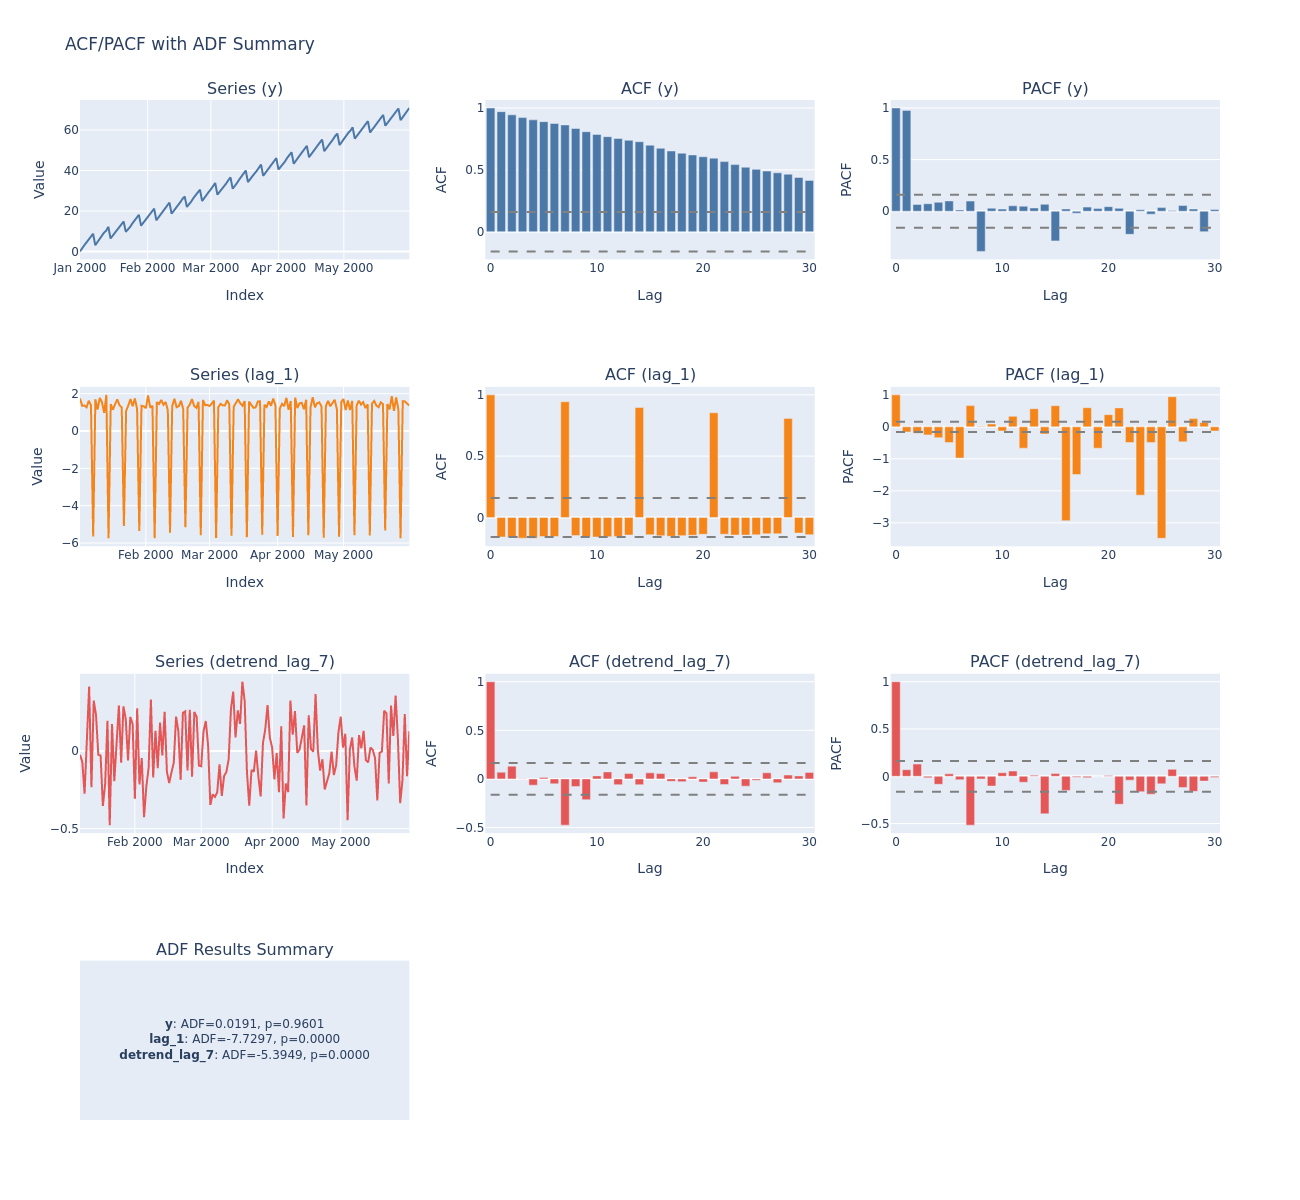

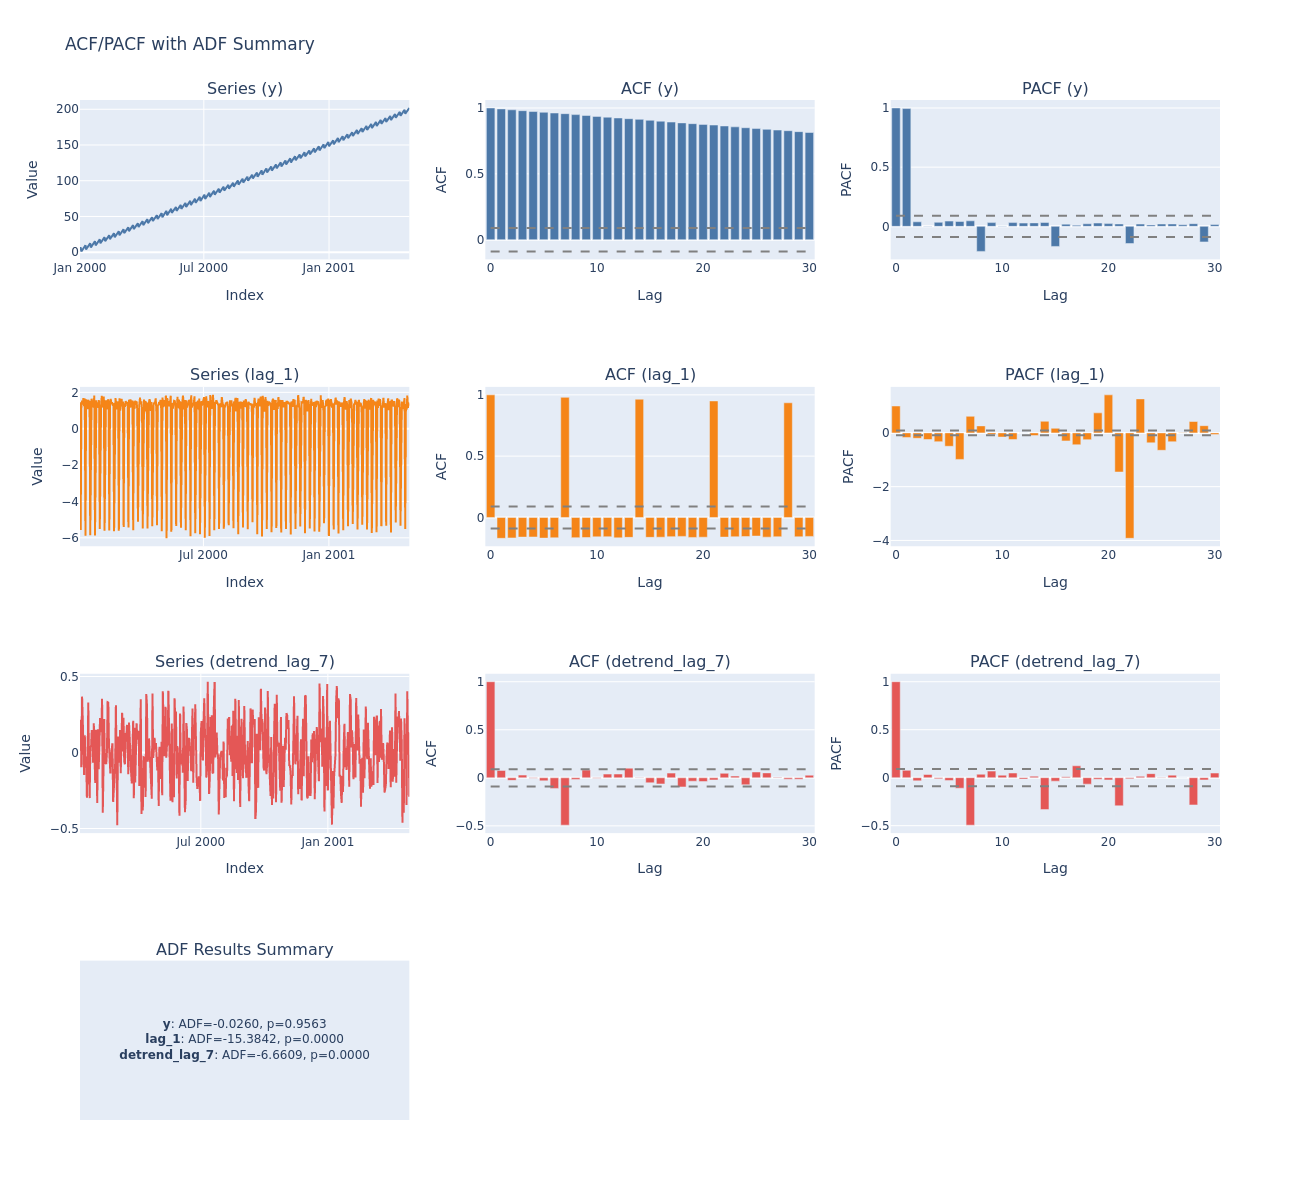

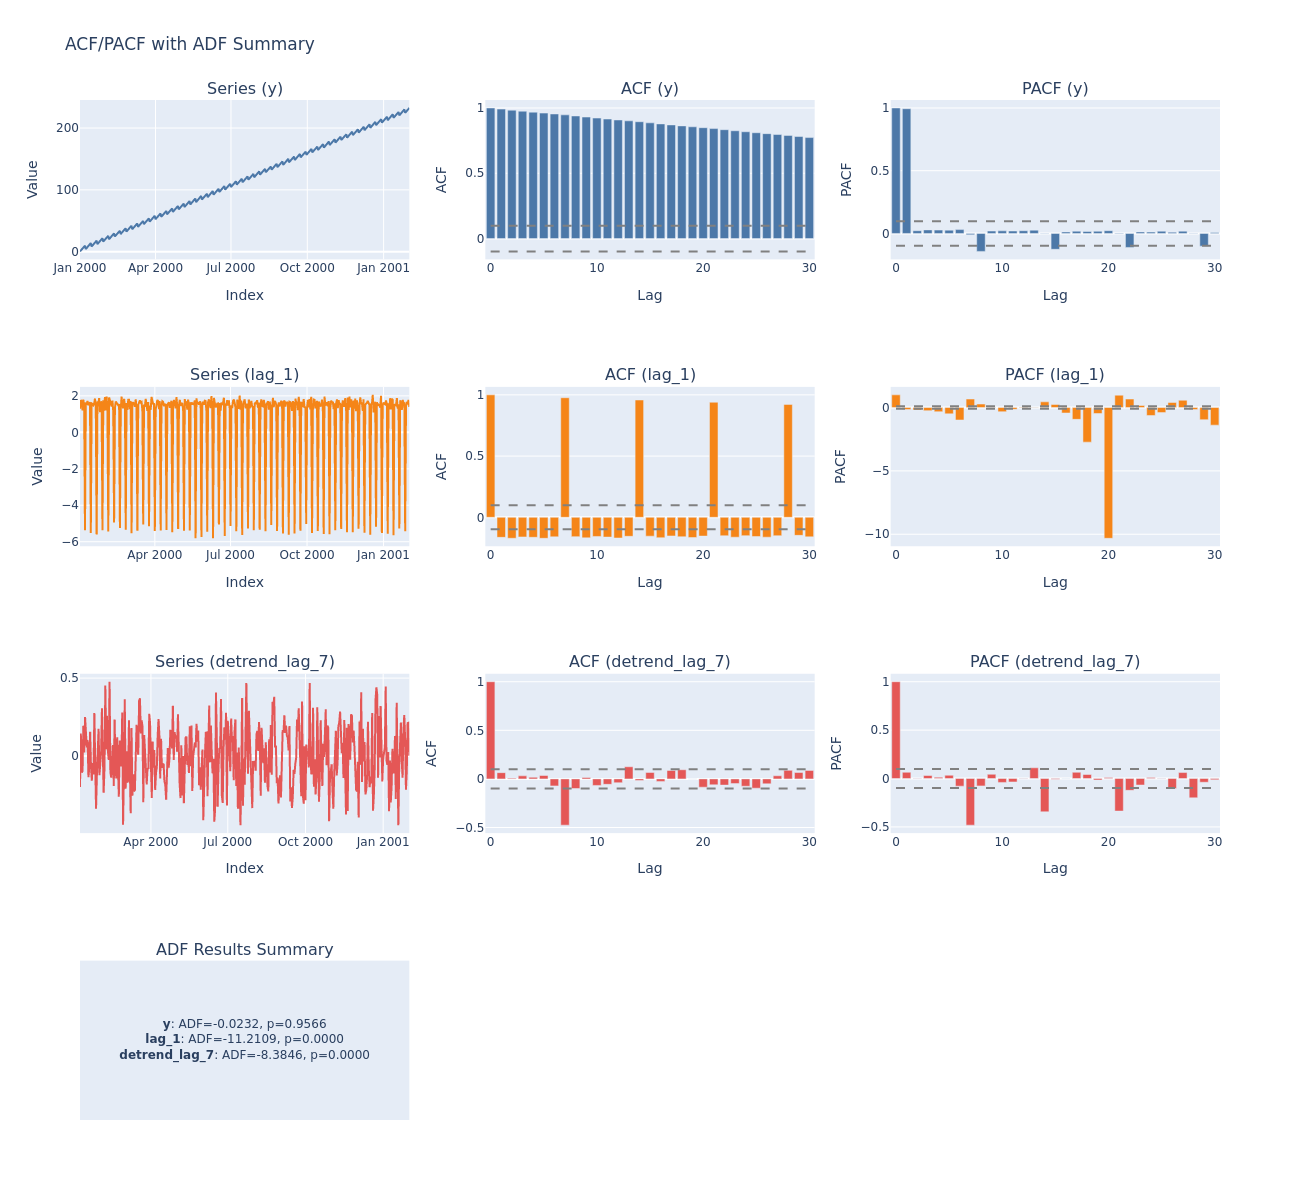

In [16]:
for id in df["unique_id"].unique():
    stationarity_check(df.loc[df["unique_id"] == id, ["y", "lag_1", "detrend_lag_7"]], fig_type="png")

# STL

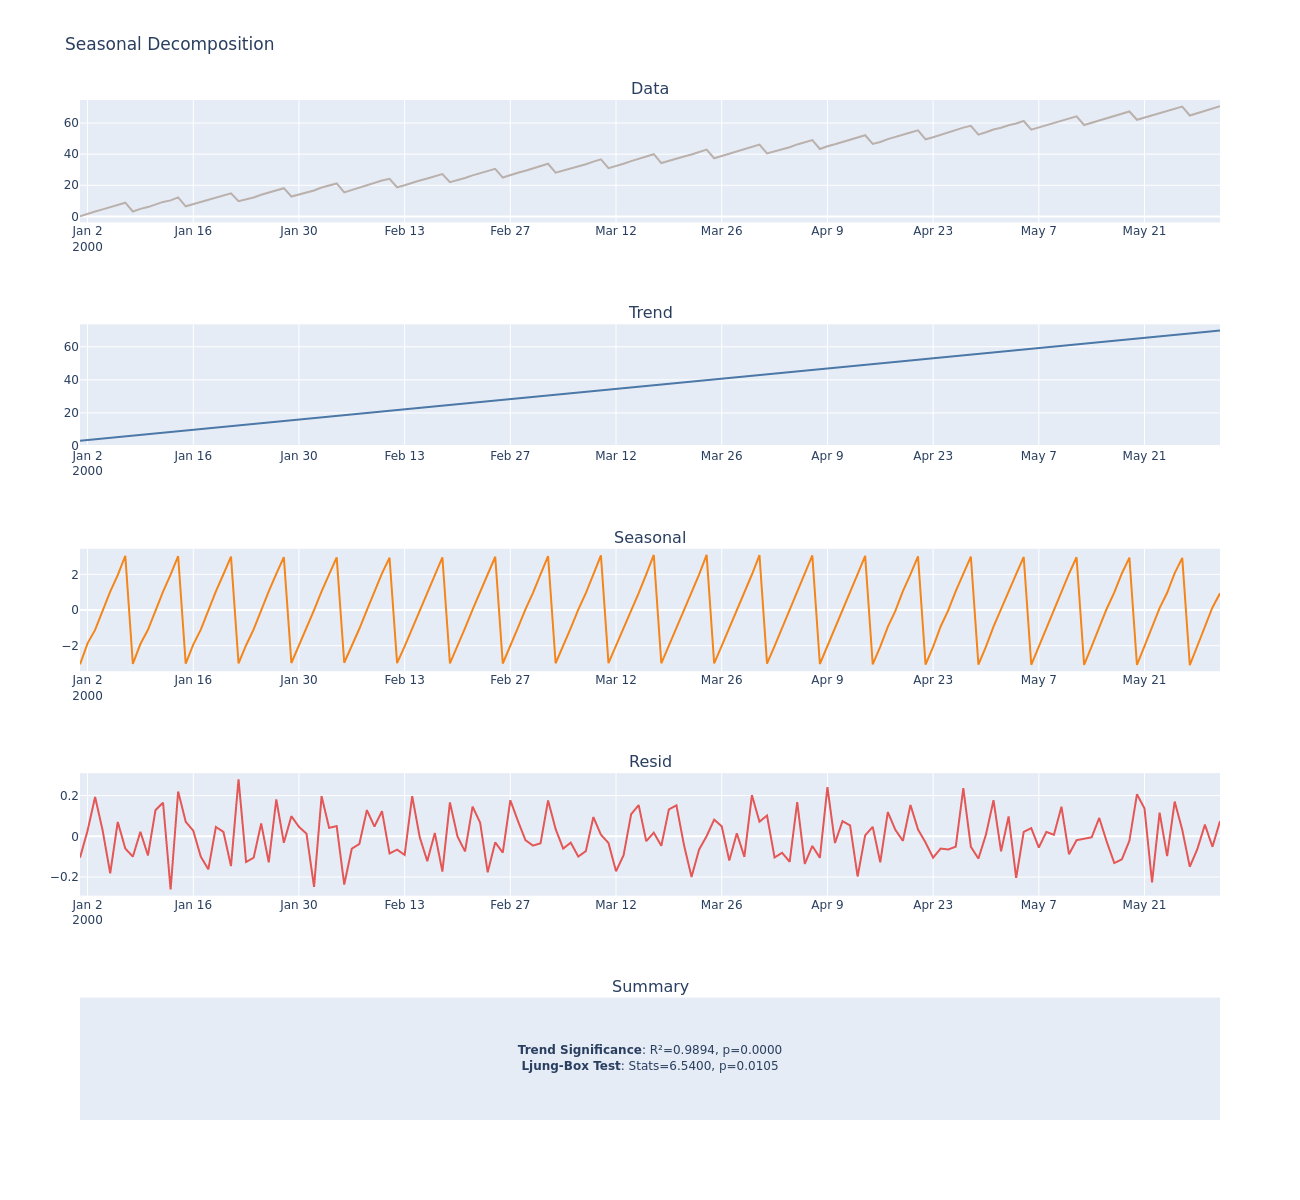

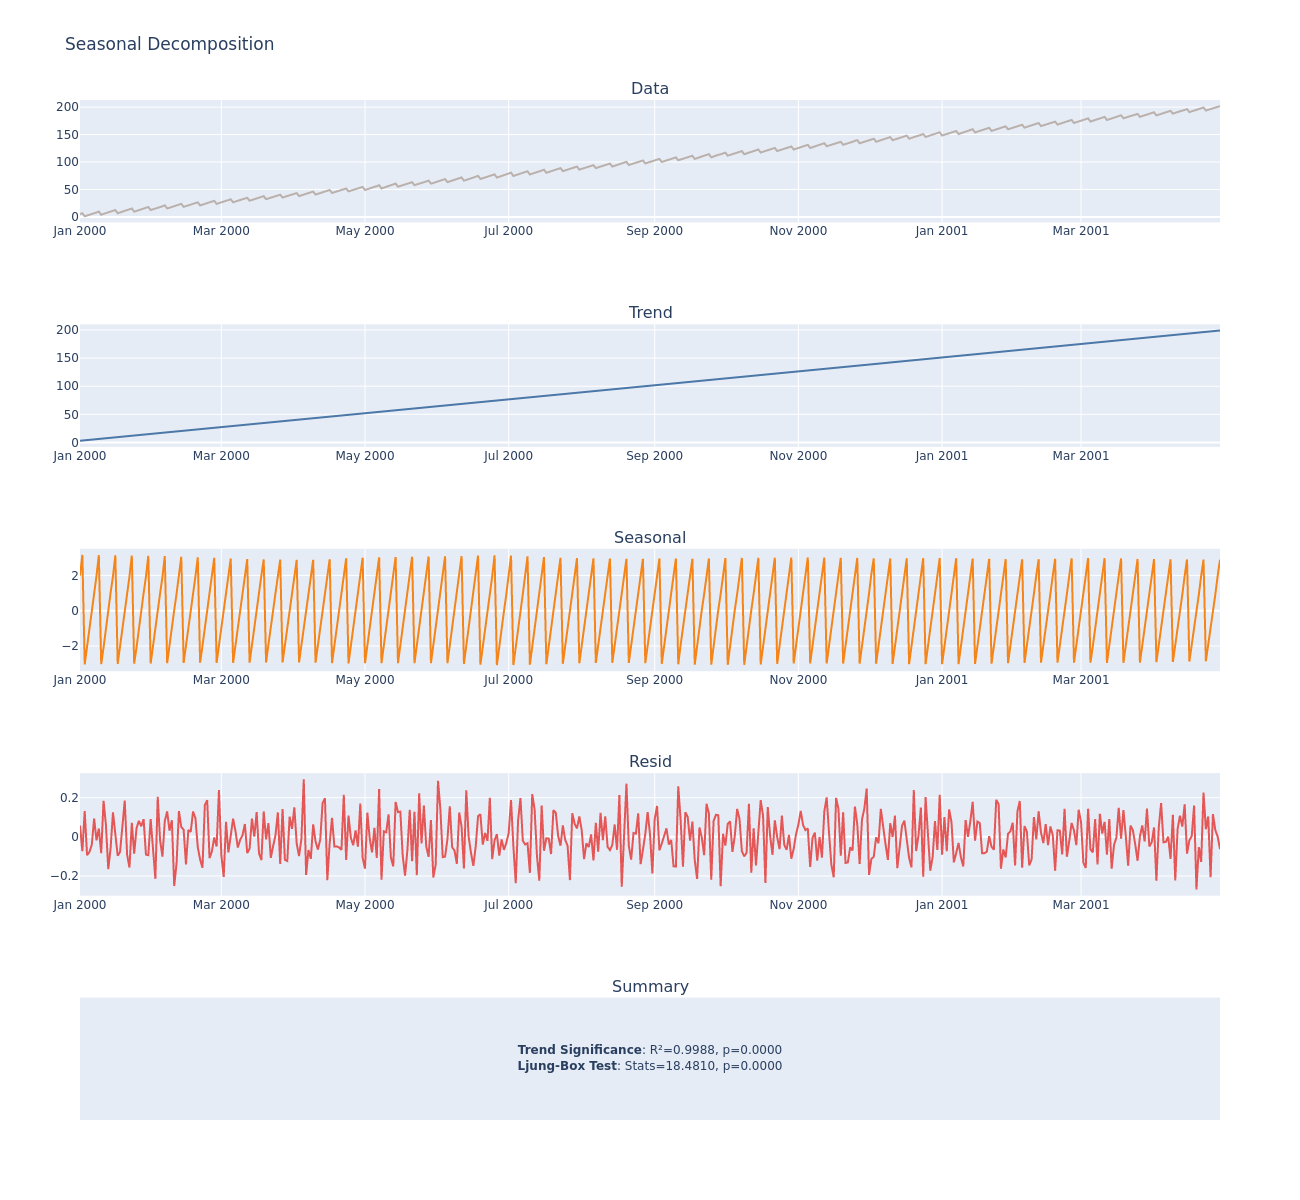

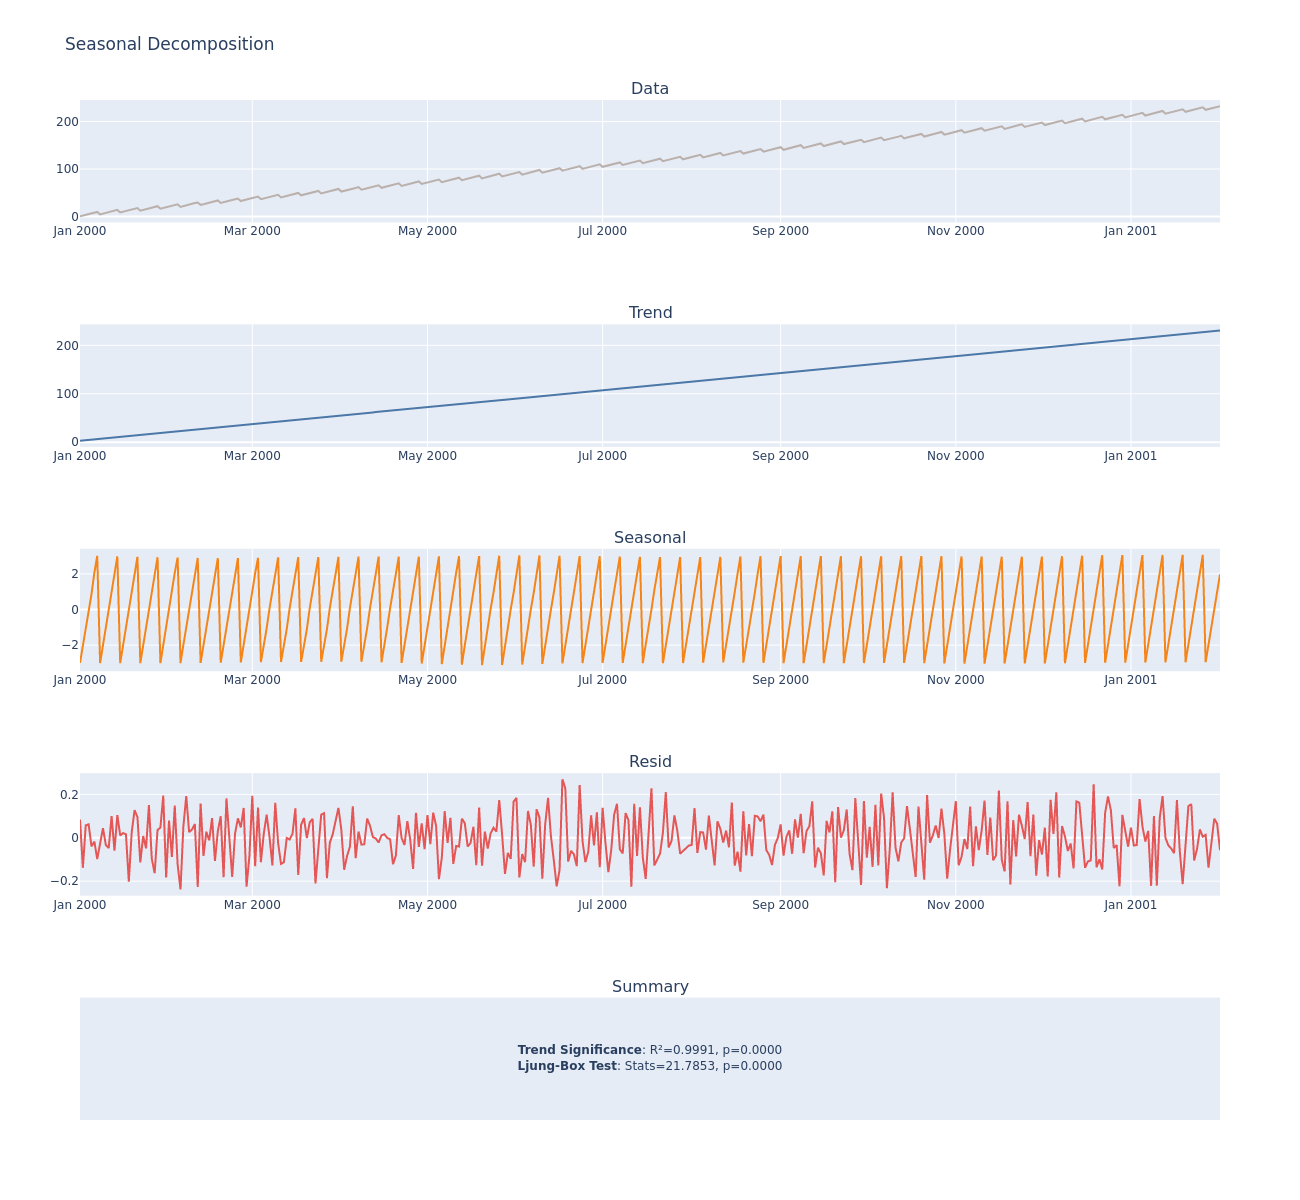

In [17]:
for id in df["unique_id"].unique():
    seasonal_decompose(
        df[df["unique_id"] == id]["y"],
        fig_type="png",
        ljung_lags=1,
        periods=7,
    )

## Features
- ~~Holidays~~
- ~~Série de fourier para padrões cíclicos (seno e cosseno) - dia da semana, dia do ano~~
- ~~mês~~
- ~~fim do mês~~
- ~~Lags~~
- Rolling Windows: médias, desvio padrão e permutação da entropia

In [18]:
df = fourier_seasonality(df.reset_index(), "ds", seasonality=["weekly", "yearly"])
holidays_br = holidays.country_holidays("Brazil")
df["is_holiday"] = np.array([timestamp in holidays_br for timestamp in df["ds"]])
df["is_month_end"] = df["ds"].dt.is_month_end

In [19]:
df = df.dropna()

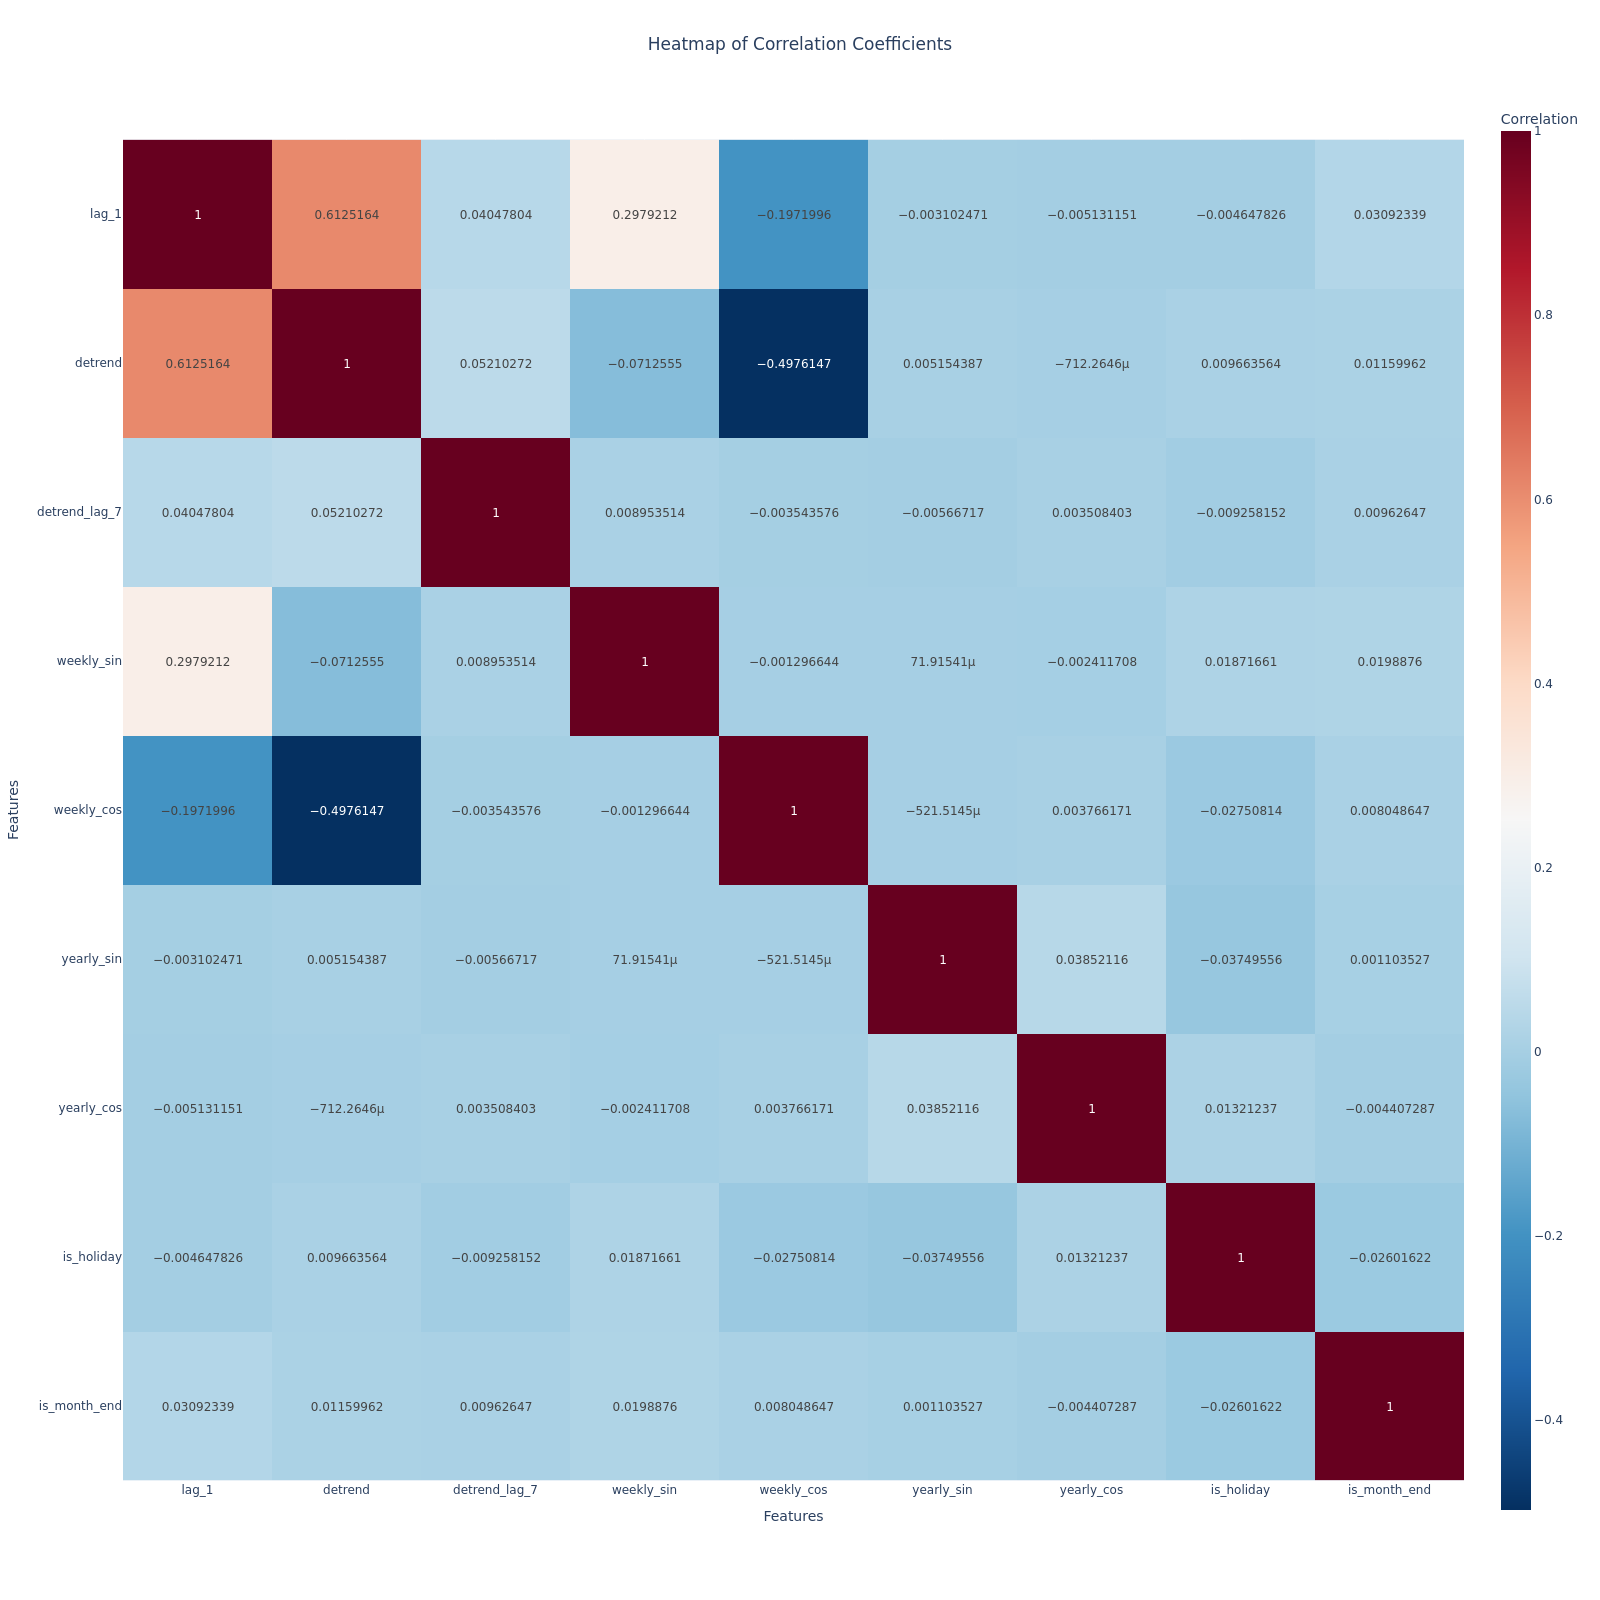

In [20]:
corr_heatmap(df[df.columns[3:]], fig_type="png")

# Modelagem Estatística

In [21]:
seasonal_length = 7
sf = StatsForecast(
    models=[
        AutoARIMA(season_length=seasonal_length),
        AutoETS(season_length=seasonal_length),
        AutoTheta(season_length=seasonal_length),
        AutoCES(season_length=seasonal_length),
    ],
    freq='D',
    fallback_model=Naive(),
    n_jobs=-1
)

In [22]:
horizon = 30
train = df.groupby('unique_id').head(-horizon).reset_index(drop=True)
test = df.groupby('unique_id').tail(horizon).reset_index(drop=True)

In [23]:
def wape(actual, forecast):
    return np.sum(np.abs(actual - forecast)) / np.sum(np.abs(actual))

In [24]:
fc = sf.forecast(df=train[["unique_id", "ds", "y"]], h=horizon) #fit_predict

In [25]:
metrics = [
    mae,
    rmse,
    bias,
    cfe
]
models = ["AutoARIMA", "AutoETS", "AutoTheta", "CES", "Ensemble"]
scum = ["AutoARIMA", "AutoETS", "AutoTheta", "CES"]

In [26]:
fc["Ensemble"] = fc[scum].median(axis=1)
fc.loc[fc["Ensemble"] < 1e-1, "Ensemble"] = 0

In [27]:
test = pd.merge(test, fc, on=["unique_id", "ds"], how="inner")
columns = ["unique_id", 
               "ds", 
               "y", 
               "AutoARIMA", 
               "AutoETS", 
               "AutoTheta", 
               "CES", 
               "Ensemble"]

In [28]:
test.groupby("unique_id")[test.columns].apply(lambda x: wape(x["y"], x["Ensemble"]))

unique_id
0    0.011617
1    0.001238
2    0.001326
dtype: float64

In [29]:
test.groupby("unique_id")[test.columns].apply(lambda x: wape(x["y"], x["AutoARIMA"]))

unique_id
0    0.001863
1    0.000636
2    0.000530
dtype: float64

In [30]:
evaluate(test[columns], 
         metrics=metrics, 
         models=models, 
         id_col="unique_id", 
         time_col="ds", 
         target_col="y")

,unique_id,metric,AutoARIMA,AutoETS,AutoTheta,CES,Ensemble
0,0,mae,0.118204,0.117160,2.817782,4.788348,0.736980
1,1,mae,0.122864,0.127738,4.450999,0.553172,0.239391
2,2,mae,0.117889,0.121499,4.293438,0.793892,0.294835
3,0,rmse,0.143891,0.136838,3.266078,5.625206,1.137482
4,1,rmse,0.141319,0.148544,5.085648,0.661118,0.315662
5,2,rmse,0.145919,0.152464,4.885838,0.914052,0.399064
6,0,bias,0.047541,0.021202,0.676148,4.788348,0.709622
7,1,bias,0.017623,0.023643,0.722320,0.546096,0.180858
8,2,bias,-0.004643,0.036408,0.834656,0.784464,0.255051
9,0,cfe,1.426229,0.636056,20.284450,143.650430,21.288656


# Análise de Resíduo

In [31]:
test["residual_arima"] = test["y"] - test["AutoARIMA"]
test["residual_ets"] = test["y"] - test["AutoETS"]
test["residual_autotheta"] = test["y"] - test["AutoTheta"]
test["residual_ces"] = test["y"] - test["CES"]
test["residual_ensemble"] = test["y"] - test["Ensemble"]

In [ ]:
for id in test["unique_id"].unique():
    stationarity_check(test.loc[test["unique_id"] == id, ["residual_arima", "residual_ets", "residual_autotheta", "residual_ces", "residual_ensemble"]], nlags=15, fig_type="png")

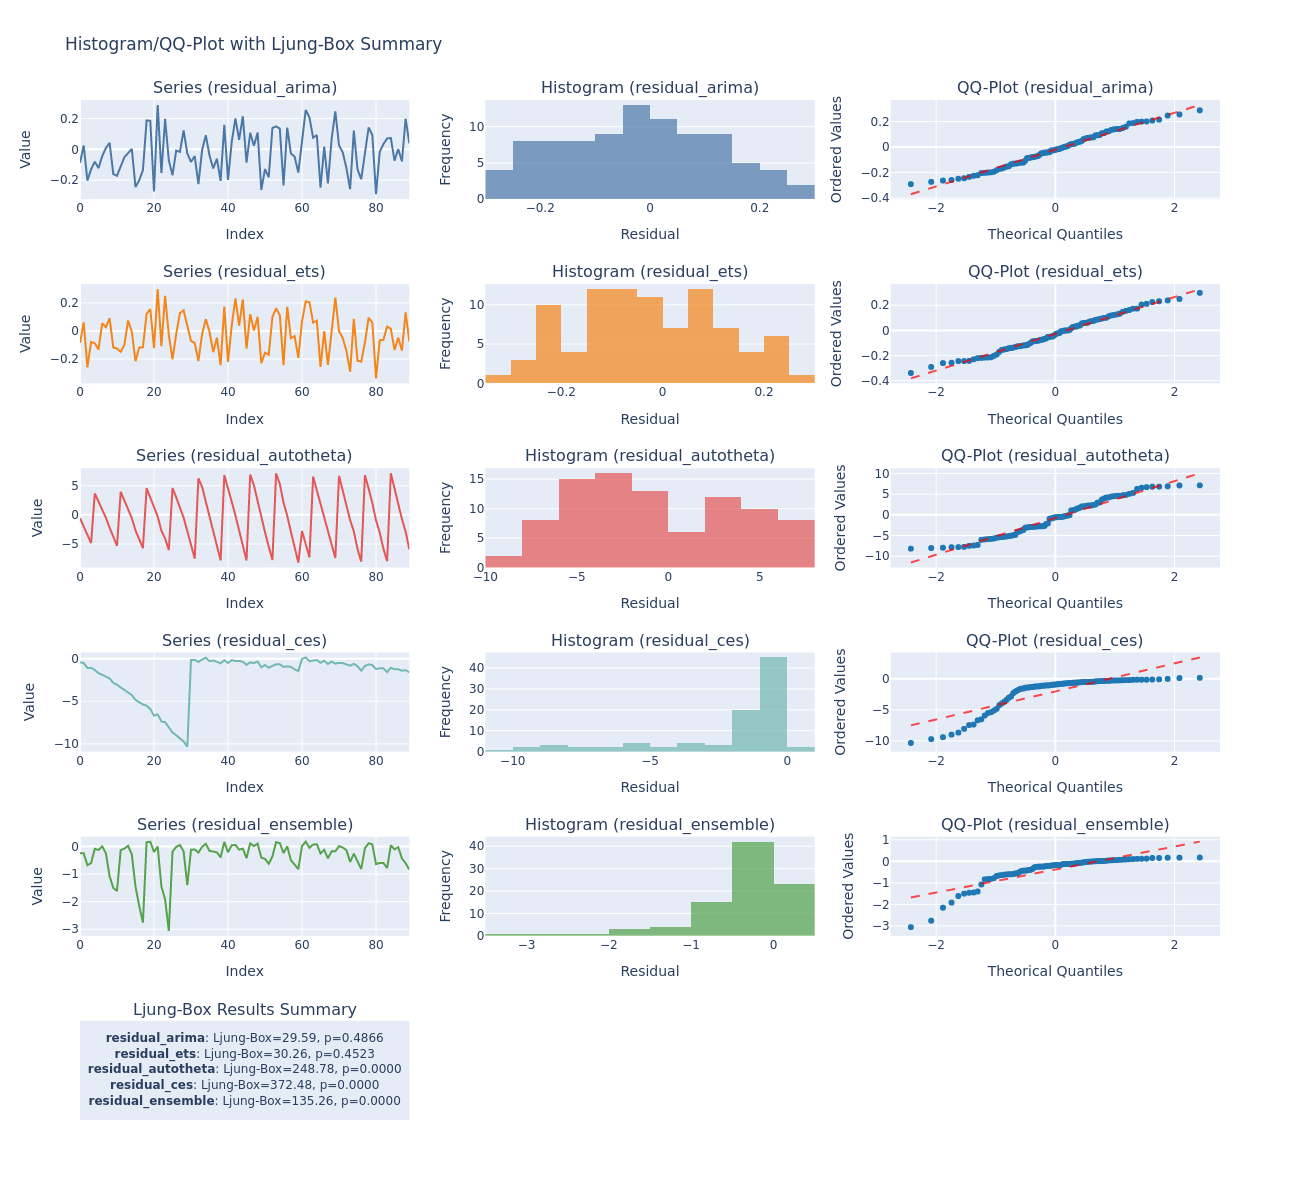

In [34]:
residual_check(test[["residual_arima", "residual_ets", "residual_autotheta", "residual_ces", "residual_ensemble"]], fig_type="png")

# Modelagem (Decomposição + Modelagem Residual)

1. modelo estatístico + ML residual
2. ver como fazer Tendência aditivia, sazonalidade multiplicativa
3. ver como fazer tendência aditiva, sazonalidade aditiva